# Stock Price Prediction Based on Tree Models

### Goal: We aim to establish models that predicts the (Adj Close) price after 5 days with the current and historical data of the Carriage Service Inc. stock which can be downloaded from https://finance.yahoo.com/quote/CSV/history/.

### Data: From the earliest record 1996-08-09 to 2019-07-15 (when this project starts) found in the above link.

### Warning: The time lag between the features we use in our models and the target (Adj Close) is at least 5 days. No historical data within a 4-day range of the to-be-predicted Adj Close price is and should be used! In particular, no data of the date of the to-be-predicted Adj Close price should be used. (If you already know the result, there is nothing to be predicted! You are late when the result comes out.)

### Why 5 days but not less: We found that predictions of a short time lag (prediction for prices say 1 day or 3 days later) with machine learning models are worse than the simple guessing method (the latest available Adj Close price in the historical data as the prediction price for a later date) in terms of accuracy. Maybe we could try harder with models with a shorter time lag but that is not the theme of this notebook.

### The significance: Our most accurate predictive model gives higher accuracy than trivial guessing methods: 1.the price after 5 days is today's price; 2.the price after 5 days is the mean of today's price and the prices of several previous days. This model gives shareholders confidence on buying or selling stocks without waiting until the last day to see almost the exact price.

### Models and Features: Gradient Boosting (including XGBoost) and Random Forest for regression. We use historical prices (Open, High, Low, Close, Adj Close) out of a 4-day range of the target and statistics generated by them measuring fluctuation as predictive features.

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np

## Load data and generate features

In [3]:
CarriageService = pd.read_csv('gdrive/My Drive/CarriageServicesStockPrice.csv')
CarriageService.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-08-09,14.250,16.750,14.250,16.500,15.264661,1601500
1,1996-08-12,16.500,16.750,16.375,16.500,15.264661,260900
2,1996-08-13,16.500,16.750,16.375,16.375,15.149018,162800
3,1996-08-14,16.375,16.625,16.375,16.375,15.149018,59500
4,1996-08-15,16.625,16.625,16.375,16.625,15.380298,62300


Text(0, 0.5, 'USD')

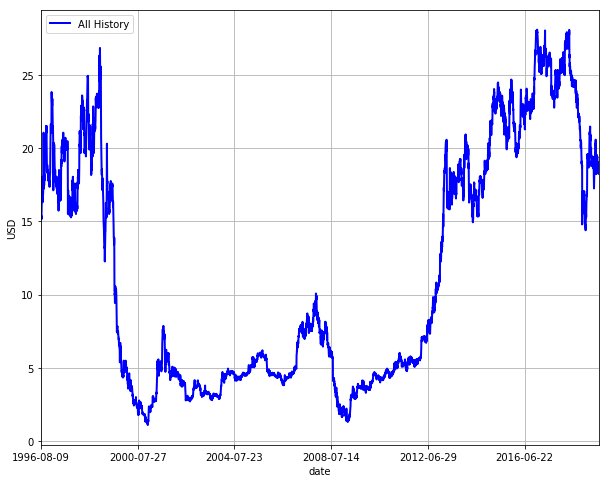

In [50]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = CarriageService.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax.legend(['All History'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

#### Extract the Adj Close price.

In [0]:
price_sequence = np.array(CarriageService[['Adj Close']]).reshape(1,-1)[0]

#### Adj Close price in 10 consective days as a row. Row 1 includes Day 0-9; Row 2 from Day 1-10 etc. Store these rows in an array.

In [0]:
def feature_row(start_index):
    return [price_sequence[i] for i in range(start_index,start_index+10)]

In [0]:
feature = []
for i in range(len(price_sequence)-9):
    feature.append(feature_row(i))
feature = np.array(feature)

In [7]:
feature.shape

(5761, 10)

#### The p-norm of the historical data (out of a 4-day range of the predicted). $\|X\|^{p} = (E |X|^{p})^{1/p} = (\int |X|^{p})^{1/p}$ approximated by  $(\sum_{i=1}^{n} 1/n\times|X_{i}|^{p})^{1/p}$. Note the Riemann sum is used to approximate the integral. We can also use the strong law of large number for reasoning.

In [0]:
def p_norm(row,p):
    return (np.mean([item**p for index, item in enumerate(row[0:len(row)-5])]))**(1/p)

#### The mean absolute deviation from the p-norm.

In [0]:
def p_norm_abs_deviation(row,p):
    return np.mean([np.abs(item-p_norm(row,p)) for index, item in enumerate(row[0:len(row)-5])])

#### The $\|. \|_{p}$ deviation of the historical data from $\|X\|_{p}$ approximated by the Riemann sum.

In [0]:
def p_norm_p_deviation(row,p):
    return np.sum([np.abs(item-p_norm(row,p))**p for index, item in enumerate(row[0:len(row)-5])])**(1/p)

#### The difference between the 75th-percentile and the 25th percentile of the historical data.

In [0]:
def percentile_deviation(row):
    return np.percentile(row[0:len(row)-5],75) - np.percentile(row[0:len(row)-5],25)

#### The difference between the max and the min of the historical data.

In [0]:
def max_min_deviation(row):
    return np.max(row[0:len(row)-5]) - np.min(row[0:len(row)-5])

#### Calculate the fluctuation statistics.

In [0]:
max_min_dev = np.array([max_min_deviation(item) for index, item in enumerate(feature)]).reshape(-1,1) 
percentile_dev = np.array([percentile_deviation(item) for index, item in enumerate(feature)]).reshape(-1,1) 

l1_abs_dev = np.array([p_norm_abs_deviation(item,1) for index, item in enumerate(feature)]).reshape(-1,1)
l2_abs_dev = np.array([p_norm_abs_deviation(item,2) for index, item in enumerate(feature)]).reshape(-1,1)
l3_abs_dev = np.array([p_norm_abs_deviation(item,3) for index, item in enumerate(feature)]).reshape(-1,1)
l4_abs_dev = np.array([p_norm_abs_deviation(item,4) for index, item in enumerate(feature)]).reshape(-1,1)

l1_norm_dev = np.array([p_norm_p_deviation(item,1) for index, item in enumerate(feature)]).reshape(-1,1)
l2_norm_dev = np.array([p_norm_p_deviation(item,2) for index, item in enumerate(feature)]).reshape(-1,1)
l3_norm_dev = np.array([p_norm_p_deviation(item,3) for index, item in enumerate(feature)]).reshape(-1,1)
l4_norm_dev = np.array([p_norm_p_deviation(item,4) for index, item in enumerate(feature)]).reshape(-1,1)


high_lag_5 = np.array(CarriageService[['High']].iloc[4:len(price_sequence)-5,:]).reshape(-1,1)
low_lag_5 = np.array(CarriageService[['Low']].iloc[4:len(price_sequence)-5,:]).reshape(-1,1)
high_low_rate_lag_5 = high_lag_5 / low_lag_5

high_lag_6 = np.array(CarriageService[['High']].iloc[3:len(price_sequence)-6,:]).reshape(-1,1)
low_lag_6 = np.array(CarriageService[['Low']].iloc[3:len(price_sequence)-6,:]).reshape(-1,1)
high_low_rate_lag_6 = high_lag_6 / low_lag_6


open_lag_5 = np.array(CarriageService[['Open']].iloc[4:len(price_sequence)-5,:]).reshape(-1,1)
close_lag_5 = np.array(CarriageService[['Close']].iloc[4:len(price_sequence)-5,:]).reshape(-1,1)
open_close_rate_lag_5 = close_lag_5 / open_lag_5

open_lag_6 = np.array(CarriageService[['Open']].iloc[3:len(price_sequence)-6,:]).reshape(-1,1)
close_lag_6 = np.array(CarriageService[['Close']].iloc[3:len(price_sequence)-6,:]).reshape(-1,1)
open_close_rate_lag_6 = close_lag_6 / open_lag_6


#### Attach the stats to the feature array.

In [0]:
feature = np.hstack([feature,max_min_dev])
feature = np.hstack([feature,percentile_dev])

feature = np.hstack([feature,l1_abs_dev])
feature = np.hstack([feature,l2_abs_dev])
#feature = np.hstack([feature,l3_abs_dev])
#feature = np.hstack([feature,l4_abs_dev])
feature = np.hstack([feature,l1_norm_dev])
feature = np.hstack([feature,l2_norm_dev])
#feature = np.hstack([feature,l3_norm_dev])
#feature = np.hstack([feature,l4_norm_dev])

feature = np.hstack([feature,high_low_rate_lag_5])
feature = np.hstack([feature,high_low_rate_lag_6])

feature = np.hstack([feature,open_close_rate_lag_5])
feature = np.hstack([feature,open_close_rate_lag_6])


In [16]:
feature = pd.DataFrame(feature)
feature.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15.264661,15.264661,15.149018,15.149018,15.380298,15.149018,15.495941,15.958508,16.305437,16.536720,0.231280,0.115643,0.074011,0.073961,0.370053,0.193504,1.015267,1.015267,1.000000,1.000000
1,15.264661,15.149018,15.149018,15.380298,15.149018,15.495941,15.958508,16.305437,16.536720,17.346199,0.231280,0.115643,0.083262,0.083318,0.416308,0.206865,1.015267,1.015267,1.000000,1.000000
2,15.149018,15.149018,15.380298,15.149018,15.495941,15.958508,16.305437,16.536720,17.346199,17.693125,0.346923,0.231280,0.138769,0.138909,0.693844,0.327085,1.022901,1.015267,1.022901,1.000000
3,15.149018,15.380298,15.149018,15.495941,15.958508,16.305437,16.536720,17.346199,17.693125,18.040056,0.809490,0.346923,0.240534,0.241110,1.202672,0.666351,1.045455,1.022901,1.029851,1.022901
4,15.380298,15.149018,15.495941,15.958508,16.305437,16.536720,17.346199,17.693125,18.040056,17.577488,1.156419,0.578210,0.379306,0.380419,1.896528,0.933852,1.036765,1.045455,1.021739,1.029851


#### Columns 0-4 are earlier historical Adj Close. Column 10 to the last column are fluctuation statistics generated by Columns 0-4. For time-efficiency towards the completion of the project, we did not rename the columns. We can always check the code above to see the exact meaning of the last columns from Column 10.





In [17]:
X = pd.concat([feature.iloc[:,0:5],feature.iloc[:,10:]],axis=1)
X.head()

,0,1,2,3,4,10,11,12,13,14,15,16,17,18,19
0,15.264661,15.264661,15.149018,15.149018,15.380298,0.231280,0.115643,0.074011,0.073961,0.370053,0.193504,1.015267,1.015267,1.000000,1.000000
1,15.264661,15.149018,15.149018,15.380298,15.149018,0.231280,0.115643,0.083262,0.083318,0.416308,0.206865,1.015267,1.015267,1.000000,1.000000
2,15.149018,15.149018,15.380298,15.149018,15.495941,0.346923,0.231280,0.138769,0.138909,0.693844,0.327085,1.022901,1.015267,1.022901,1.000000
3,15.149018,15.380298,15.149018,15.495941,15.958508,0.809490,0.346923,0.240534,0.241110,1.202672,0.666351,1.045455,1.022901,1.029851,1.022901
4,15.380298,15.149018,15.495941,15.958508,16.305437,1.156419,0.578210,0.379306,0.380419,1.896528,0.933852,1.036765,1.045455,1.021739,1.029851


#### Column 9 is our target for prediction.

In [18]:
y = feature.iloc[:,9]
y.head()

0    16.536720
1    17.346199
2    17.693125
3    18.040056
4    17.577488
Name: 9, dtype: float64

#### Scale the prediction feature data X.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#### The first 5600 records for model training. The last 161 records are used as unseen (testing) data. A more rigorous approach will be to introduce the validation set, i.e., separating the entire set as training set, validation set and testing set. 

In [0]:
X_train = X[:5600]
X_test = X[5600:]
y_train = y[:5600,]
y_test = y[5600:,]

#### Accuracies of our models. The parameters are chosen by grid search with the author's experience and understanding of the parameters. Since the tuning process is time consuming and laborous, the code is omitted for the simplicity of the presentation.

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import time
t = time.time()
GBreg = GradientBoostingRegressor(max_depth=5, n_estimators=45, alpha=0.01, min_samples_split=2, min_samples_leaf=1, random_state=0)
GBreg.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, GBreg.predict(X_test)))
print("RMSE: %.8f" % rmse)
print("MAPE: %.8f" % np.mean(np.abs(GBreg.predict(X_test)-np.array(y_test))/np.array(y_test)))
Elapsed = time.time() - t
print("Elapsed time = %.3f seconds" % Elapsed)

RMSE: 0.87754692
MAPE: 0.03765155
Elapsed time = 0.636 seconds


In [0]:
len(pd.DataFrame(reg.predict(X_test)).iloc[:,0].unique())

161

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import time
t = time.time()
xgbreg = xgb.XGBRegressor(max_depth=5, n_estimators=70, alpha=0.01, min_samples_split=2, min_samples_leaf=1, random_state=0)
xgbreg.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, xgbreg.predict(X_test)))
print("RMSE: %.8f" % rmse)
print("MAPE: %.8f" % np.mean(np.abs(reg.predict(X_test)-y_test)/y_test))
Elapsed = time.time() - t
print("Elapsed time = %.3f seconds" % Elapsed)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.87293883
MAPE: 0.03867387
Elapsed time = 0.711 seconds


In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
t = time.time()
RFreg = RandomForestRegressor(max_depth=7, n_estimators=20, min_samples_split=5, min_samples_leaf=1, random_state=0)
RFreg.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, RFreg.predict(X_test)))
print("RMSE: %.8f" % rmse)
print("MAPE: %.8f" % np.mean(np.abs(RFreg.predict(X_test)-np.array(y_test))/np.array(y_test)))
Elapsed = time.time() - t
print("Elapsed time = %.3f seconds" % Elapsed)

RMSE: 0.89852347
MAPE: 0.03867387
Elapsed time = 0.653 seconds


In [0]:
len(pd.DataFrame(reg.predict(X_test)).iloc[:,0].unique())

161

In [0]:
len(y_test)

161

#### We see that the GradientBoostRegressor gives the lowest mean absolute percentage error of 3.77% and the XGBoostRegressor gives the lowest root of the mean squared error 0.873 dollars. Let us see below how the trivial guessing method compares.

### Latest Date Price evalution method: Day $i$ price as Day $i+5$ price.

#### MAPE

In [0]:
np.mean([np.abs(item) for index, item in enumerate(np.diff(np.array([y_test[5:],y_test[0:len(y_test)-5]]).T).reshape(1,-1)/np.array(y_test[5:])[0])])

0.040665532389977575

#### RMSE

In [0]:
np.sqrt(mean_squared_error(y_test[5:],y_test[0:len(y_test)-5]))

0.8778223378594835

### Mean Price evaluation: the mean of prices of Day $i, i+1, i+2, i+3, i+4$ as the price of Day $i+5$. 

#### MAPE

In [0]:
np.mean([np.abs(item) for index, item in enumerate(np.diff(np.array([y_test.rolling(5).mean()[4:len(y_test)-5],y_test[9:]]).T).reshape(1,-1)/np.array(y_test[9:])[0])])

0.04801101961784655

#### RMSE

In [0]:
np.sqrt(mean_squared_error(y_test[9:],y_test.rolling(5).mean()[4:len(y_test)-5]))

1.0097690002027653

### Conclusion: our Gradient Boost model are more accurate in terms of both the mean squared error and the mean percentage error. We see approximated 0.3% improvement of MAPE in GB than in latest date prediction.

### Visualization of the prediction on the training set by the GB model.

Text(0, 0.5, 'USD')

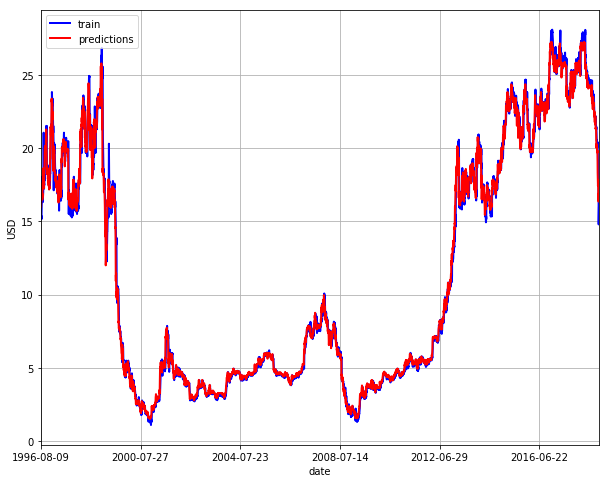

In [54]:
df = pd.concat([CarriageService.iloc[0:len(GBreg.predict(X_train))].reset_index(),pd.DataFrame(GBreg.predict(X_train))],axis=1).rename(columns = {0:'Predicted'})
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = df.plot(x='Date', y='Predicted', style='r-', grid=True, ax=ax)
ax.legend(['train', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

### Visualization of the prediction on the test set by the GB model. 

Text(0, 0.5, 'USD')

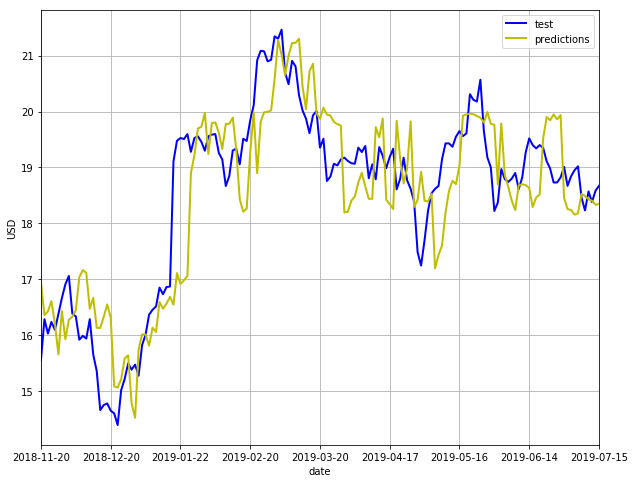

In [55]:
df = pd.concat([CarriageService.iloc[-len(GBreg.predict(X_test)):].reset_index(),pd.DataFrame(GBreg.predict(X_test))],axis=1).rename(columns = {0:'Predicted'})
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = df.plot(x='Date', y='Predicted', style='y-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")